# Baseline Models

Create baseline models to compare geneformer to on fine-tuning task

In [1]:
# /ihome/kyin/niandrew/.conda/envs/tf_gpu
# /ix1/kyin/niandrew/custom_miniconda
# source /ix1/kyin/niandrew/custom_miniconda/bin/activate tf_gpu
!source /ix1/kyin/niandrew/custom_miniconda/bin/activate tf_gpu
!export XLA_FLAGS=--xla_gpu_cuda_data_dir=/ihome/kyin/niandrew/.conda/envs/tf_gpu/lib/
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/ihome/kyin/niandrew/.conda/envs/tf_gpu/lib/

# !export CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))
# !export LD_LIBRARY_PATH=${CUDNN_PATH}/lib

## Load Packages

In [2]:
from datasets import load_dataset
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import datetime
import pandas as pd

import os
os.environ["KERAS_BACKEND"] = "jax"  # or "tensorflow" or "torch"

import keras_nlp
import tensorflow as tf
import keras

import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
import numpy as np

2024-05-06 02:19:11.612550: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 02:19:11.659189: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 02:19:12.732171: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Parameters

In [3]:
# Parameters
SEQ_LENGTH = 512

## Load Data

In [4]:
# Load Vocab File
with open('token_dictionary.pkl', 'rb') as file:
    vocab_dict = pickle.load(file)
vocab_list = list(vocab_dict.keys())
vocab_list.append('<unk>')
VOCAB_SIZE = len(vocab_list)

# Load Cell Type Label File
with open('immune-c2s/label_dictionary.pkl', 'rb') as file:
    label_dict = pickle.load(file)
label_list = list(label_dict.keys())
NUM_CLASSES = len(label_dict)

In [5]:
# Finetuning

# Tokenizer
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab_list,
    sequence_length=SEQ_LENGTH,
    lowercase=False,
    oov_token='<unk>',
    split=True
)

def preprocess(inputs, labels):
    return tokenizer(inputs), labels

2024-05-06 02:19:15.417534: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-05-06 02:19:15.417730: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43626 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:4a:00.0, compute capability: 8.9


In [6]:
train = tf.data.experimental.CsvDataset('immune-c2s/train.csv', [tf.string, tf.int32], header=False)
test = tf.data.experimental.CsvDataset('immune-c2s/test.csv', [tf.string, tf.int32], header=False)
val = tf.data.experimental.CsvDataset('immune-c2s/val.csv', [tf.string, tf.int32], header=False)

# Pre-compute preprocessed batches on the fly on the CPU.
finetune_ds = train.map(
    preprocess, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

finetune_test_ds = test.map(
    preprocess, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

finetune_val_ds = val.map(
    preprocess, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

print(finetune_val_ds.take(1).get_single_element())

(<tf.Tensor: shape=(512,), dtype=int32, numpy=
array([12172,  1720, 17247, 17200, 16979, 11842, 18941, 16596, 17326,
       25426, 19823, 13620,  9761,  7502, 25426,  3906, 17269,  8229,
         512, 12698, 16910,   454,  7606, 25426, 25426, 25426,  9215,
       11358,  8256, 17295,  3482, 10390, 17303,  6861,  6022, 25426,
       25426, 25426,  9945, 25426, 17314, 10511, 25426, 10877,  8160,
       10225,  7892, 17905,  9940,  8231,  3502,  8456, 15602,  3664,
       19999, 17228, 17208,  3567, 20069,  8385, 16445, 25426, 25426,
        3081, 14125,  1513,  2649, 13128, 15993,  6961,  8565, 13058,
        2183, 12504,  3792, 24346,  8385, 18971,  9142,  2400,  5448,
       14983, 16980,  8177, 17297,  1522, 13620,   391,  2992, 25426,
         998,  4761,  8456,  7111,   309,  4387,  8626,  1823,  7422,
       10639, 15506, 11319,  8981,   856,  5304, 14180,  6206,  3537,
        2522, 25426,  6681, 25426, 19770,  3039, 13062, 11032,  6881,
        3141, 16572, 25426,  1543,  8674, 1

## Convert Data

In [7]:
def convert_to_numpy(tf_dataset):
    """ Convert a tf.data.Dataset to numpy arrays for sklearn compatibility. """
    features_list, labels_list = [], []
    for features, labels in tf_dataset:
        features_list.append(features)
        labels_list.append(labels)
    return np.array(features_list), np.array(labels_list)

In [8]:
# Load Data
X_train, y_train = convert_to_numpy(finetune_ds)
X_test, y_test = convert_to_numpy(finetune_test_ds)
X_val, y_val = convert_to_numpy(finetune_val_ds)

2024-05-06 02:19:30.933910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-06 02:19:34.617791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-06 02:19:36.996997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Baseline Models

In [11]:
# Initialize models
models_multi = {
    "Naive Bayes": MultinomialNB(),
    "MLP (Neural Network)": MLPClassifier(hidden_layer_sizes=(256,256), activation='relu', solver='adam', verbose=1),
    "Random Forest": RandomForestClassifier(verbose=1, n_jobs=32),
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', verbose=1, n_jobs=32)
}

# Train each model
for name, model in models_multi.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    print(f"{name} trained successfully")

Training Naive Bayes...
Naive Bayes trained successfully
Training MLP (Neural Network)...
Iteration 1, loss = 27.00735340
Iteration 2, loss = 12.90173372
Iteration 3, loss = 5.49376756
Iteration 4, loss = 3.73693186
Iteration 5, loss = 3.43925650
Iteration 6, loss = 3.81799249
Iteration 7, loss = 3.05029645
Iteration 8, loss = 2.93890494
Iteration 9, loss = 2.90681398
Iteration 10, loss = 2.89540567
Iteration 11, loss = 2.89035228
Iteration 12, loss = 2.88780232
Iteration 13, loss = 2.88645665
Iteration 14, loss = 2.88575295
Iteration 15, loss = 2.88538216
Iteration 16, loss = 2.88517982
Iteration 17, loss = 2.88507422
Iteration 18, loss = 2.88501587
Iteration 19, loss = 2.88496583
Iteration 20, loss = 2.88492495
Iteration 21, loss = 2.88493968
Iteration 22, loss = 2.88491888
Iteration 23, loss = 2.88492156
Iteration 24, loss = 2.88491149
Iteration 25, loss = 2.88490369
Iteration 26, loss = 2.88490845
Iteration 27, loss = 2.88490156
Iteration 28, loss = 3.09611378
Training loss did not

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:   30.1s finished
/ihome/kyin/niandrew/.conda/envs/tf_gpu/lib/python3.9/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Random Forest trained successfully
Training Logistic Regression...


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        17955     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55535D+00    |proj g|=  2.44675D+03


 This problem is unconstrained.



At iterate   50    f=  2.47503D+00    |proj g|=  1.36946D+02

At iterate  100    f=  2.40313D+00    |proj g|=  5.54175D+01

At iterate  150    f=  2.38649D+00    |proj g|=  3.84029D+01

At iterate  200    f=  2.37568D+00    |proj g|=  3.77182D+01

At iterate  250    f=  2.37021D+00    |proj g|=  4.91331D+01

At iterate  300    f=  2.36541D+00    |proj g|=  3.97481D+01

At iterate  350    f=  2.36258D+00    |proj g|=  2.57730D+01

At iterate  400    f=  2.36015D+00    |proj g|=  2.09298D+01

At iterate  450    f=  2.35888D+00    |proj g|=  2.37976D+01

At iterate  500    f=  2.35816D+00    |proj g|=  8.82157D+00

At iterate  550    f=  2.35733D+00    |proj g|=  1.04246D+01

At iterate  600    f=  2.35660D+00    |proj g|=  4.64794D+00

At iterate  650    f=  2.35598D+00    |proj g|=  9.98990D+00

At iterate  700    f=  2.35545D+00    |proj g|=  5.60184D+00

At iterate  750    f=  2.35506D+00    |proj g|=  5.97272D+00

At iterate  800    f=  2.35477D+00    |proj g|=  6.08163D+00

At iter

/ihome/kyin/niandrew/.conda/envs/tf_gpu/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
# Save models
with open("model/baseline_multi.pkl", 'wb') as file:
    pickle.dump(models_multi, file)

In [15]:
with open("model/baseline_multi.pkl", 'rb') as file:
    models_multi = pickle.load(file)

In [17]:
predictions = {}

for name, model in models_multi.items():
    predictions[name] = model.predict(X_val)

def predict_keras_model(model, dataset):
    """ Predict using a Keras model with a tf.data.Dataset. """
    predictions = model.predict(dataset)
    # Assuming binary classification and sigmoid activation, adjust if necessary
    return np.argmax(predictions, axis=1)
    
# Add Keras model predictions
finetuning_model = keras.models.load_model("model/geneformer_cell_classifier_multi.keras", compile=True)
predictions["Geneformer"] = predict_keras_model(finetuning_model, X_val)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.2s finished
/ihome/kyin/niandrew/.conda/envs/tf_gpu/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 206 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/ihome/kyin/niandrew/.conda/envs/tf_gpu/lib/python3.9/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/ihome/kyin/niandrew/.conda/envs/tf_gpu/lib/python3.9/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a ma

856/856 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step


In [18]:
model_accuracies_multi = {}

for name, pred in predictions.items():
    model_accuracies_multi[name] = accuracy_score(y_val, pred)

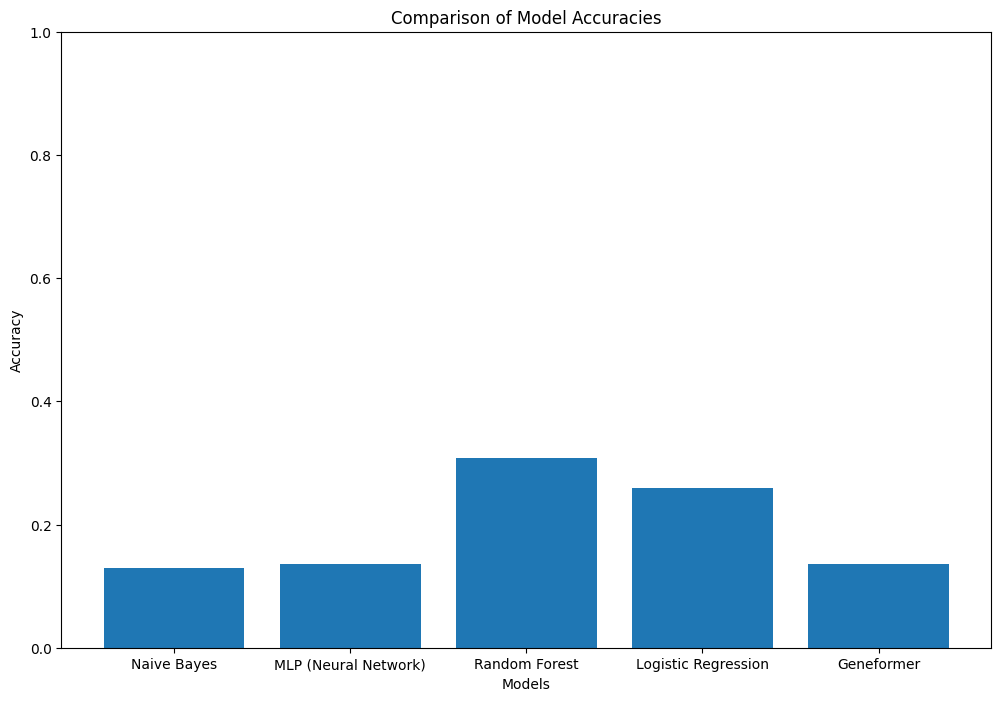

In [19]:
# Plotting the accuracies
plt.figure(figsize=(12, 8))
plt.bar(model_accuracies_multi.keys(), model_accuracies_multi.values())
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim([0, 1])  # Accuracy ranges from 0 to 1
plt.show()

## Load Data

In [20]:
# Load Vocab File
with open('token_dictionary.pkl', 'rb') as file:
    vocab_dict = pickle.load(file)
vocab_list = list(vocab_dict.keys())
vocab_list.append('<unk>')
VOCAB_SIZE = len(vocab_list)

# Load Cell Type Label File
with open('immune-c2s/label_binary_dictionary.pkl', 'rb') as file:
    label_dict = pickle.load(file)
label_list = list(label_dict.keys())
NUM_CLASSES = len(label_dict)

In [21]:
# Finetuning

# Tokenizer
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab_list,
    sequence_length=SEQ_LENGTH,
    lowercase=False,
    oov_token='<unk>',
    split=True
)

def preprocess(inputs, labels):
    return tokenizer(inputs), labels

In [22]:
train = tf.data.experimental.CsvDataset('immune-c2s/train-binary.csv', [tf.string, tf.int32], header=False)
test = tf.data.experimental.CsvDataset('immune-c2s/test-binary.csv', [tf.string, tf.int32], header=False)
val = tf.data.experimental.CsvDataset('immune-c2s/val-binary.csv', [tf.string, tf.int32], header=False)

# Pre-compute preprocessed batches on the fly on the CPU.
finetune_ds = train.map(
    preprocess, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

finetune_test_ds = test.map(
    preprocess, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

finetune_val_ds = val.map(
    preprocess, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

print(finetune_val_ds.take(1).get_single_element())

(<tf.Tensor: shape=(512,), dtype=int32, numpy=
array([ 1720,  8385, 12172, 16596,   512, 18941, 25426,  3906,  7502,
       25426, 11842, 17200, 16979,  1876, 13620, 17247,  8229, 10887,
       19823, 17326,  8256, 19437,  8981,  3482,  5401, 25426,   309,
        7892,  9945, 17314, 17303,  1522,  2400, 11049,  6022,   299,
       25426, 25426, 10877,  5448,   454,  3792, 10888,  8231,  6861,
       17905,   998, 16445,  3502, 19999, 17297, 12504,  7913, 16980,
        9940, 14180,  3537,   396,  3192,  6681,  2985,  3664,  5304,
       17295,  8674, 10225, 25426, 25426, 11358, 20069, 10639, 25426,
       10511,  7606, 17269,  2649, 25426,  2522, 11347, 11319,  8565,
        3081,   695,  8456, 25426,  9215,  1984, 25426, 25426, 25426,
       14125,  4387, 10871, 25426,  2992,  5950,  3141, 16910, 13062,
       25426, 25426, 25426,  4698,  6238, 13128,  1823, 25426, 17005,
        8626, 13058,  7492, 15803,  5246,  5212,  7111, 10689,  2360,
        8578,  6206,  9581,  2770, 14120, 1

## Convert Data

In [23]:
def convert_to_numpy(tf_dataset):
    """ Convert a tf.data.Dataset to numpy arrays for sklearn compatibility. """
    features_list, labels_list = [], []
    for features, labels in tf_dataset:
        features_list.append(features)
        labels_list.append(labels)
    return np.array(features_list), np.array(labels_list)

In [24]:
# Load Data
X_train, y_train = convert_to_numpy(finetune_ds)
X_test, y_test = convert_to_numpy(finetune_test_ds)
X_val, y_val = convert_to_numpy(finetune_val_ds)

2024-05-06 02:33:00.947997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-06 02:33:01.639666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-06 02:33:02.099339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Baseline Models

In [26]:
# Initialize models
models = {
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(verbose=1, n_jobs=32),
    "Logistic Regression": LogisticRegression(max_iter=1000, verbose=1, n_jobs=32),
    "MLP (Neural Network)": MLPClassifier(hidden_layer_sizes=(256,256), activation='relu', solver='adam', verbose=1)
}

# Train each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    print(f"{name} trained successfully")

Training Naive Bayes...
Naive Bayes trained successfully
Training Random Forest...


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.


Random Forest trained successfully
Training Logistic Regression...


[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
/ihome/kyin/niandrew/.conda/envs/tf_gpu/lib/python3.9/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          513     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  3.59712D+03


 This problem is unconstrained.



At iterate   50    f=  4.25233D-01    |proj g|=  4.07238D-01

At iterate  100    f=  4.25233D-01    |proj g|=  3.08285D-01

At iterate  150    f=  3.99453D-01    |proj g|=  2.15076D+02

At iterate  200    f=  1.26884D-01    |proj g|=  4.23256D+00

At iterate  250    f=  1.26812D-01    |proj g|=  4.42395D-01

At iterate  300    f=  1.26811D-01    |proj g|=  4.73807D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  513    305    367      1     0     0   2.858D-04   1.268D-01
  F =  0.12681104764772561     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Logistic Regression trained successfully
Training M

In [27]:
# Save models
with open("model/baseline.pkl", 'wb') as file:
    pickle.dump(models, file)

In [28]:
with open("model/baseline.pkl", 'rb') as file:
    models = pickle.load(file)

In [29]:
predictions = {}

for name, model in models.items():
    predictions[name] = model.predict(X_val)

def predict_keras_model(model, dataset):
    """ Predict using a Keras model with a tf.data.Dataset. """
    predictions = model.predict(dataset)
    # Assuming binary classification and sigmoid activation, adjust if necessary
    return (predictions.ravel() > 0.5).astype(int)
    
# Add Keras model predictions
finetuning_model = keras.models.load_model("model/geneformer_cell_classifier_binary.keras", compile=True)
predictions["Geneformer"] = predict_keras_model(finetuning_model, X_val)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished
/ihome/kyin/niandrew/.conda/envs/tf_gpu/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 206 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/ihome/kyin/niandrew/.conda/envs/tf_gpu/lib/python3.9/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/ihome/kyin/niandrew/.conda/envs/tf_gpu/lib/python3.9/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a ma

121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step


In [30]:
model_accuracies = {}

for name, pred in predictions.items():
    model_accuracies[name] = accuracy_score(y_val, pred)

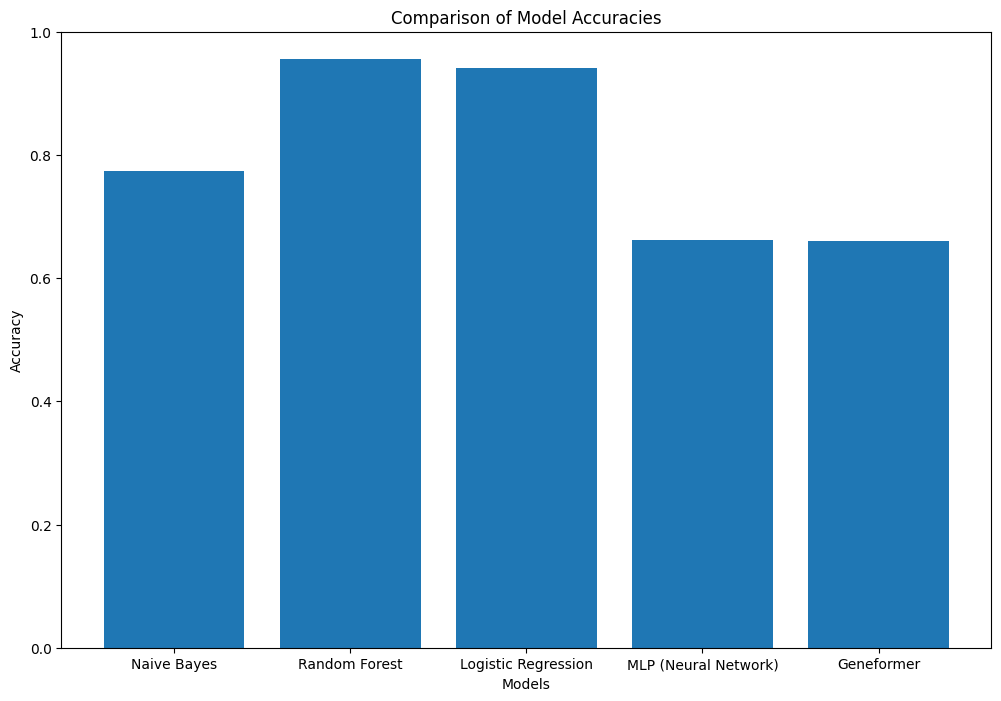

In [31]:
# Plotting the accuracies
plt.figure(figsize=(12, 8))
plt.bar(model_accuracies.keys(), model_accuracies.values())
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim([0, 1])  # Accuracy ranges from 0 to 1
plt.show()

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

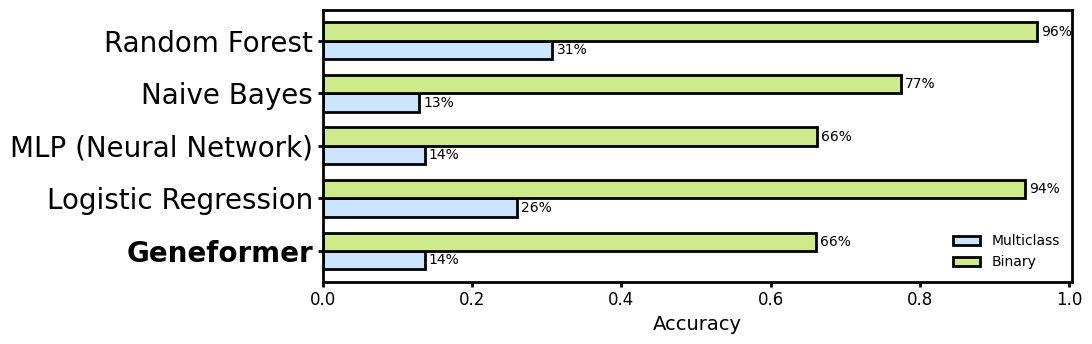

In [92]:
labels = sorted(model_accuracies.keys())
multiclass_scores = [model_accuracies_multi[label] for label in labels]
binary_scores = [model_accuracies[label] for label in labels]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(11, 3.5))  # Set the figure size to 12x8 inches

fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)  # Setting the axes background to be transparent

rects1 = ax.barh(x - width/2, multiclass_scores, width, label='Multiclass', color='#CCE5FF', edgecolor='black', linewidth=2)
rects2 = ax.barh(x + width/2, binary_scores, width, label='Binary', color='#CDEB8B', edgecolor='black', linewidth=2)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Accuracy', fontsize=14)
# ax.set_title('Comparison of Geneformer to Baseline')
ax.set_yticks(x)
ax.set_yticklabels(labels, fontsize=20)
legend = ax.legend()
legend.get_frame().set_alpha(0.0)  # Make the legend background transparent
legend.get_frame().set_linewidth(0.0)  # Removes the box around the legend

for spine in ax.spines.values():
    spine.set_linewidth(2)
        
# Bold the label 'Geneformer'
for label in ax.get_yticklabels():
    if label.get_text() == "Geneformer":
        label.set_fontweight('bold')
        
# Function to add labels on bars
def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{:.0f}%'.format(100*round(width, 2)),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(3, 0),  # Slight offset to the right of the bar end
                    textcoords="offset points",
                    ha='left', va='center',
                    rotation=0)  # Ensures text is horizontal

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
ax.tick_params(axis='x', which='major', labelsize=12, width=2) 
ax.tick_params(axis='y', which='major', width=2) 

plt.savefig('baseline.png', format='png', transparent=True, dpi=2400)

plt.show()